In [1]:
# installing chrome driver
!apt update
!apt install chromium-chromedriver
!pip install selenium-stealth
!pip install selenium
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && apt install ./google-chrome-stable_current_amd64.deb

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [518 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:5 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [1,156 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,000 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,037 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://ppa.launchpadcontent.net/

In [2]:
#Importing required libraries

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium_stealth import stealth
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
from time import sleep
from formattingData import FlightInformation
from fileWriter import Source
import re
import requests
import pandas as pd

In [3]:
# setting the required web driver

options = webdriver.ChromeOptions()
#run Selenium in headless mode
options.add_argument('--headless')
options.add_argument('--no-sandbox')
#disable infobars
options.add_argument("disable-infobars")
#open Browser in maximized mode
options.add_argument("start-maximized")
#overcome limited resource problems
options.add_argument('--disable-dev-shm-usage')
options.add_argument("lang=en")
#disable extension
options.add_argument("--disable-extensions")
options.add_argument("--incognito")
options.add_argument("--disable-blink-features=AutomationControlled")

driver = webdriver.Chrome(options=options)

stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )

## Scraping Kayak.com

In [4]:
# code for kayak.com

def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser in maximized mode
    options.add_argument("start-maximized")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text

def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )

def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Kayak",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Kayak(Source):
    def __init__(self):
        url = (
            "https://kayak.com/flights/HEL-NYC/2023-10-26/2023-11-02?sort=bestflight_a"
        )
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    f = Kayak()
    f.save_file()


Message: element click intercepted: Element <div role="button" tabindex="0" class="ULvh-button show-more-button">...</div> is not clickable at point (422, 24). Other element would receive the click: <div role="button" tabindex="0" class="NITa NITa-location-inline NITa-hasValue NITa-mod-multi-values">...</div>
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x5c955ddfb6b3 <unknown>
#1 0x5c955dad11e7 <unknown>
#2 0x5c955db1e65d <unknown>
#3 0x5c955db1c9fd <unknown>
#4 0x5c955db1a7b8 <unknown>
#5 0x5c955db19827 <unknown>
#6 0x5c955db0e4f9 <unknown>
#7 0x5c955db3a0c2 <unknown>
#8 0x5c955db0df16 <unknown>
#9 0x5c955db3a28e <unknown>
#10 0x5c955db53322 <unknown>
#11 0x5c955db39e93 <unknown>
#12 0x5c955db0c934 <unknown>
#13 0x5c955db0d71e <unknown>
#14 0x5c955ddc0cb8 <unknown>
#15 0x5c955ddc4bf0 <unknown>
#16 0x5c955ddcf19c <unknown>
#17 0x5c955ddc5808 <unknown>
#18 0x5c955dd9227f <unknown>
#19 0x5c955dde9e88 <unknown>
#20 0x5c955ddea059 <unknown>
#21 0x5c955ddfa843 <unknown>


# Scraping Momondo.com

In [5]:
# code for momondo.com

def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser in maximized mode
    options.add_argument("start-maximized")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Momondo",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Momondo(Source):
    def __init__(self):
        url = "https://www.momondo.com/flight-search/HEL-NYC/2023-10-20/2023-11-10?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    m = Momondo()
    m.save_file("a")


Scraping Website
 Finnair
 Lufthansa
 Finnair
 Finnair
 Finnair
 Finnair
 Finnair, American Airlines
 Finnair, British Airways
 Finnair, British Airways
 Finnair
 Finnair
 Finnair, American Airlines
 Finnair
 Finnair
 Xfly, CityJet
 Finnair
 Delta
 Finnair
 Lufthansa CityLine
 KLM
 Finnair, British Airways
 United Airlines, Lufthansa CityLine
 Finnair
 Finnair, American Airlines
 Finnair
 Lufthansa
 Finnair
 Xfly, CityJet
 Finnair
 Xfly, CityJet
 Lufthansa
 Finnair, American Airlines
 KLM
 Finnair
 Finnair
 KLM, Air France
 Lufthansa
 Lufthansa
 Finnair
 Lufthansa CityLine
 Lufthansa
 Lufthansa
 Lufthansa CityLine
 KLM
 SAS Connect, CityJet
 American Airlines
 Lufthansa CityLine
 United Airlines, Lufthansa CityLine
 United Airlines, Lufthansa CityLine
 Finnair
 Finnair, American Airlines
 Finnair, American Airlines
 Finnair
 United Airlines
 Lufthansa
 KLM
 Lufthansa
 SAS Connect, CityJet
 Finnair, American Airlines
 Finnair
 American Airlines
 Lufthansa
 United Airlines, Lufthansa
 Un

# Scraping Booking.com

In [6]:
# code for booking.com

def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator a.moreButton")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
    #run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    #overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
    #open Browser in maximized mode
    options.add_argument("start-maximized")
    #disable infobars
    options.add_argument("disable-infobars")
    #disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.resultsPaginator"))
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    for list_element in transits:
        depart_list = list_element.find_all("div", "col-field time depart")
        depart_location = find_text_elements(depart_list[0], "bottom", "div")
        arrival_list = list_element.find_all("div", "col-field time return")
        arrival_location = find_text_elements(arrival_list[0], "bottom", "div")
        transit_location = None
        airport_name = None
        layover_time = None

        if depart_location == "HEL":
            flight_stop = list_element.find("div", "bottom stops").text
            direct_flight = flight_stop == "\nnonstop "
            if not direct_flight:
                transit_location = find_text_elements(
                    list_element=list_element, selector="js-layover"
                )
                transit_details = list_element.find("span", "js-layover")["title"]
                transit_time = transit_details.split("layover,")
                layover_time = transit_time[0]
                # print("Layover time", layover_time[0])
                pattern = r"<b>(.*?)</b>"
                match = re.findall(pattern, transit_details)
                airport_name = match[0]
                # print("Transit airport:", airport_name)
            depart_time = find_text_elements(
                list_element=list_element, selector="depart-time base-time"
            )
            arrival_time = find_text_elements(
                list_element=list_element, selector="arrival-time base-time"
            )
            duration_div = list_element.find("div", "col-field duration")
            flight_duration = duration_div.find("div", "top").text
            # print("Depart", depart_time)
            # print("Arrival", arrival_time)
            return (
                "HEL",
                arrival_location,
                direct_flight,
                transit_location,
                layover_time,
                airport_name,
                depart_time,
                arrival_time,
                flight_duration,
            )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "flight")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find("div", "section disclosures")
        # print(airlines_div)
        if airlines_div is not None:
            airlines_name = find_text_elements(airlines_div, "section operators", "div")
            print("airlines_name", airlines_name.split("\nOperated by ")[1])
            price = None
            booking_dropdown = flights.find_all("div", "multibook-dropdown")
            price = find_text_elements(booking_dropdown[0], "price-text", "span")
            source = find_text_elements(booking_dropdown[0], "name-only-text", "span")
            flight_info = FlightInformation(
                airline_names=airlines_name.split("\nOperated by ")[1],
                departure_time=flight[6],
                arrival_time=flight[7],
                departure_location=flight[0],
                arrival_destination=flight[1],
                flight_duration=flight[-1],
                direct_flight=flight[2],
                layover_time=flight[4],
                transit_location=flight[3],
                transit_airport=flight[5],
                flight_price=price.split("\n")[1],
                source=source.split("\n")[1],
                scraped_website="Booking.com",
            )
            list_structured_flight.append(flight_info)
    return list_structured_flight


class Booking_Com(Source):
    def __init__(self):
        url = "https://booking.kayak.com/flights/HEL-NYC/2023-10-22/2023-11-02?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="inner-grid keel-grid")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    f = Booking_Com()
    # saving the data into a Pandas dataframe

    f.save_file("a")


Scraping Website
airlines_name Finnair 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, Aer Lingus (U.K.) Limited For Aer Lingus 
airlines_name Iberia For Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Lufthansa 
airlines_name Lufthansa CityLine 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, Aer Lingus (U.K.) Limited For Aer Lingus 
airlines_name Iberia For Finnair, American Airlines 
airlines_name Finnair 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name Lufthansa, Lufthansa CityLine 
airlines_name Finnair, British Airways 
airlines_name Finnair, Ame

Step 3: Exploratory Data Analysis ( EDA )

In [7]:
# importing libraries required for visualization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import missingno as msno

from pandas.core.base import value_counts

In [ ]:
# Reading flight data from a CSV file
df = pd.read_csv('flight.csv')

# checking first few rows of the DataFrame to understand the structure of the data
print(df.head())



In [9]:
df = pd.read_csv('flight.csv', sep=',')
df.dropna(inplace=True)
print(df)

                            Airlines Name Departure Time Arrival Time  \
263           Finnair, American Airlines           4:00        10:53    
264           Finnair, American Airlines           2:05         7:58    
265           Finnair, American Airlines           8:00         1:30    
266                            Lufthansa           1:40         8:05    
267                   Lufthansa CityLine           1:40         8:05    
..                                    ...            ...          ...   
389             Finnair, British Airways           8:00         1:50    
390                              Finnair           8:00         1:30    
391             Finnair, British Airways           4:00        10:53    
393             Finnair, British Airways           7:35         2:38    
395  United Airlines, Lufthansa CityLine          12:45         8:05    

    Departure Location Arrival Destination Flight Duration  Direct FLight  \
263                HEL                 JFK    

In [10]:
# Load data from CSV file
flights_data = pd.read_csv('flight.csv')

airlines_with_more_than_350_data = flights_data['Airlines Name'].value_counts() > 350
filtered_data = flights_data[flights_data['Airlines Name'].isin(airlines_with_more_than_350_data.index)]

print (filtered_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 371 entries, 0 to 395
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Airlines Name        371 non-null    object
 1   Departure Time       371 non-null    object
 2   Arrival Time         371 non-null    object
 3   Departure Location   371 non-null    object
 4   Arrival Destination  371 non-null    object
 5   Flight Duration      371 non-null    object
 6   Direct FLight        371 non-null    bool  
 7   Layover Time         255 non-null    object
 8   Transit Location     255 non-null    object
 9   Transit Airport      105 non-null    object
 10  Price                371 non-null    object
 11  Source Link          139 non-null    object
 12  Scraped Website      371 non-null    object
dtypes: bool(1), object(12)
memory usage: 38.0+ KB
None


In [ ]:
print(filtered_data.head())

filtered_data['Airlines Name'] = filtered_data['Airlines Name'].str.strip()

print(filtered_data['Airlines Name'].unique())



In [12]:
filtered_data = filtered_data.dropna(subset=['Airlines Name'])
filtered_data['Airlines Name'] = filtered_data['Airlines Name'].str.lower()
print(filtered_data['Airlines Name'].value_counts())
print(filtered_data['Airlines Name'].unique())

finnair                                              73
finnair, american airlines                           57
lufthansa cityline                                   39
lufthansa                                            33
lufthansa, lufthansa cityline                        19
finnair, british airways                             19
american airlines                                    19
united airlines, lufthansa cityline                  18
sas connect, xfly                                    12
united airlines, lufthansa                           11
sas connect                                           9
klm                                                   8
united airlines                                       6
iberia for finnair, american airlines                 5
xfly, smartlynx                                       3
xfly, jettime a/s                                     3
united airlines, lufthansa, lufthansa cityline        3
smartlynx                                       

In [13]:
filtered_data['Airlines Name'] = filtered_data['Airlines Name'].str.strip()

Countplot: Shows the number of flights for each airline.

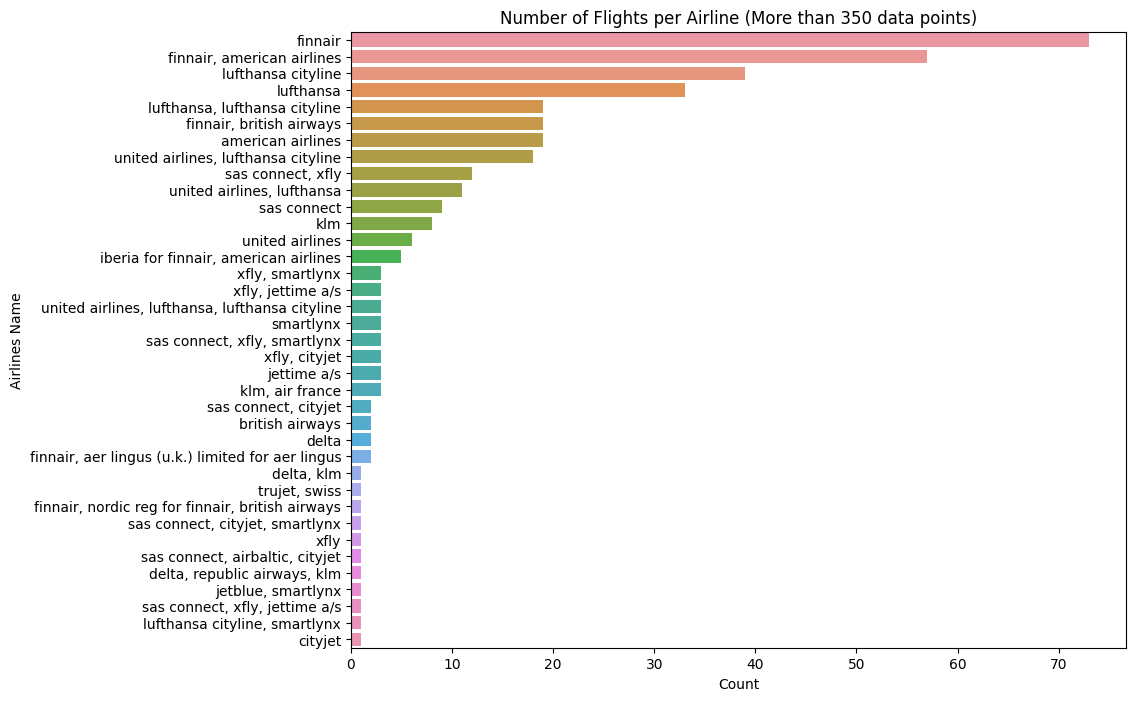

In [14]:
# Create a countplot for the selected airlines
plt.figure(figsize=(10, 8))
sns.countplot(y=filtered_data['Airlines Name'], order=filtered_data['Airlines Name'].value_counts().index)
plt.title('Number of Flights per Airline (More than 350 data points)')
plt.xlabel('Count')
plt.ylabel('Airlines Name')
plt.show()


Visualizing Airlines Name

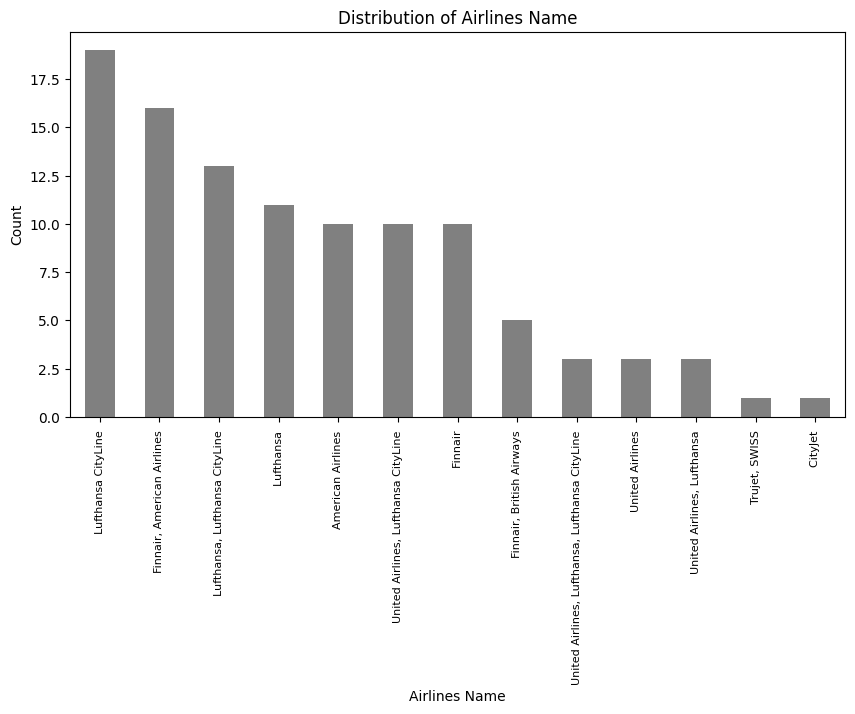

In [15]:
column_name = 'Airlines Name'
category_counts = df[column_name].value_counts()
plt.figure(figsize=(10, 5))
category_counts.plot(kind='bar', color='grey')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Distribution of {column_name}')
plt.xticks(rotation=90, fontsize=8)
plt.show()

Visualizing number of stops

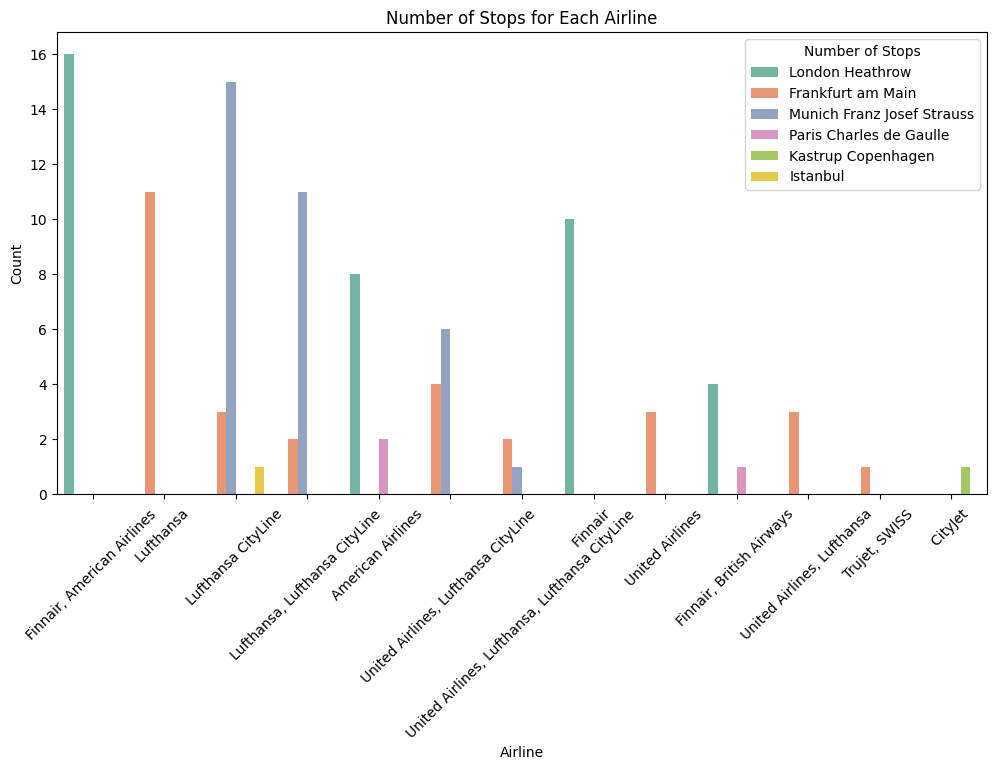

In [16]:
# Create a countplot for the number of stops for each airline
plt.figure(figsize=(12, 6))
sns.countplot(x='Airlines Name', hue='Transit Airport', data=df, palette='Set2')
# 'Set2' is a color palette, you can choose another one if you prefer
plt.title('Number of Stops for Each Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.legend(title='Number of Stops', loc='upper right')
plt.xticks(rotation=45)
plt.show()

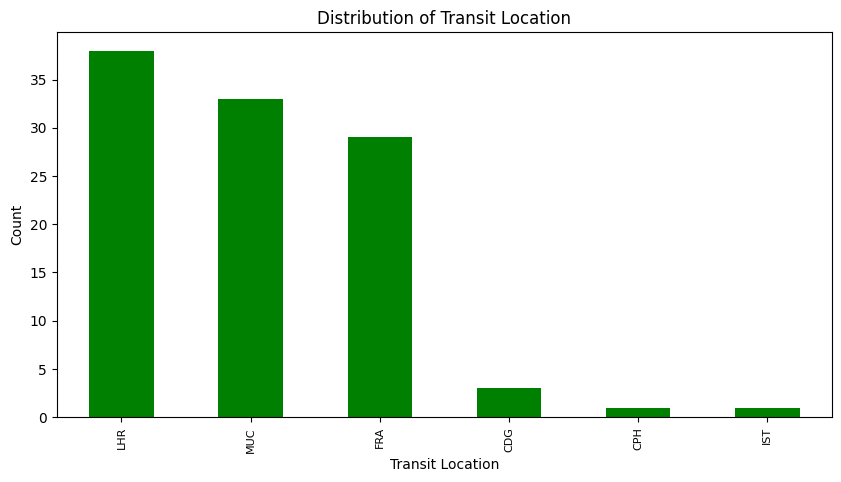

In [17]:
column_name = 'Transit Location'
category_counts = df[column_name].value_counts()
plt.figure(figsize=(10, 5))
category_counts.plot(kind='bar', color='green')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Distribution of {column_name}')
plt.xticks(rotation=90, fontsize=8)
plt.show()

Price Ranges for different Airlines

ValueError: ignored

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Calculate average price for each airline
#average_prices = df.groupby('Airlines Name')['Price'].mean().reset_index()
average_prices['Price'] = pd.to_numeric(average_prices['Price'])
# Create a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Airlines Name', y='Price', data=average_prices, palette='viridis')
plt.title('Average Price by Airline')
plt.xlabel('Airlines Name')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# visualizing price ranges
# Convert 'Price' column to numeric (if needed)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(subset=['Price'], inplace=True)
# Convert 'Airlines Name' to categorical (if needed)
df['Airlines Name'] = pd.Categorical(df['Airlines Name'])

plt.figure(figsize=(14, 6))
sns.boxplot(x='Airlines Name', y='Price', data=df, palette='Set2')
plt.title('Price Ranges for Different Airlines')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()



In [36]:
# Remove $ from price

df['Price'] = df['Price'].replace('[\$,]', '', regex=True).astype(float)

# Convert time to hours
def time_to_hours(time):
    if not isinstance(time, str):
        return None

    try:
        #hours, minutes = time.split('h')
        #hours = float(hours)
        #minutes = float(minutes.split('m')[0]) / 60
        #total_hours = hours + minutes
       # return total_hours
        hours, minutes = map(int, time_string.split(' hours '))
        total_hours = hours + minutes / 60
        return total_hours

    except ValueError:
        return None

flight_hours = []
layover_hours = []

for time_string in df['Layover Time']:
    total_hours = time_to_hours(time_string)
    layover_hours.append(total_hours)

df['Layover Time'] = layover_hours

for time_string in df['Flight Duration']:
    total_hours = time_to_hours(time_string)
    flight_hours.append(total_hours)

df['Flight Duration'] = flight_hours

# Convert the depart/arrive time column to datetime format and extract the hour component
df['Departure Time'] = pd.to_datetime(df['Departure Time'], errors='coerce')
df['Departure Hour'] = df['Departure Time'].dt.hour

df['Arrival Time'] = df['Arrival Time'].str.lstrip()
df['Arrival Time'] = df['Arrival Time'].str.replace(r'\+\d', '')
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], errors='coerce')
df['Arrival Hour'] = df['Arrival Time'].dt.hour

<ipython-input-36-cd163d59408f>:43: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Arrival Time'] = df['Arrival Time'].str.replace(r'\+\d', '')


### User Interaction

In [78]:
#User Interaction
import csv

class Flight:
    def __init__(self, airline, price, duration, stops, layover_duration, aircraft_type):
        self.airline = airline
        self.price = price
        self.duration = duration
        self.stops = stops
        self.layover_duration = layover_duration
        self.aircraft_type = aircraft_type

def convert_time_to_minutes(time_string):
      if time_string:
        pattern = r'(\d+)\s*h?\s*(\d*)\s*m?'
        matches = re.findall(pattern, time_string)

        if matches:
            hours = int(matches[0][0])
            minutes = int(matches[0][1]) if matches[0][1] else 0
            total_minutes = hours * 60 + minutes
            return total_minutes
        return 0


def read_flights_from_csv(file_path):
    flights = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
           # Remove commas from the 'Price' field and convert it to float
            price = float(row['Price'].replace(',', '').replace('$', ''))
            # Convert 'Flight Duration' to minutes
            flight_duration = convert_time_to_minutes(row['Flight Duration'])
            # Store 'Transit Location' as a string
            transit_location = row['Transit Location']
            # Convert 'Layover Duration' to minutes
            layover_duration = convert_time_to_minutes(row['Layover Time'])
            aircraft_type = row['Airlines Name']
            flight = Flight(row['Airlines Name'], price, flight_duration, transit_location, layover_duration, aircraft_type)
            flights.append(flight)
    return flights

def filter_flights(user_preferences, flights):
    filtered_flights = []
    for flight in flights:
        if (user_preferences["price_min"] <= flight.price <= user_preferences["price_max"] and
            user_preferences["duration_min"] <= flight.duration <= user_preferences["duration_max"] and
            (user_preferences["direct_flight"] and flight.stops == 0) or
            (not user_preferences["direct_flight"] and flight.stops > 0 and flight.layover_duration <= user_preferences["layover_max"]) and
            flight.airline in user_preferences["airlines"]):
            filtered_flights.append(flight)
    return filtered_flights

# User input for flight preferences
user_preferences = {
    "price_min": float(input("Enter minimum price: ")),
    "price_max": float(input("Enter maximum price: ")),
    "duration_min": float(input("Enter minimum duration ( in minutes ) : ")),
    "duration_max": float(input("Enter maximum duration ( in minutes ): ")),
    "direct_flight": input("Direct flight only? (yes/no): ").lower() == "yes",
    "layover_max": float(input("Enter maximum layover duration ( in minutes ): ")),
    "airlines": input("Enter preferred airlines (comma-separated): ").split(",")
}

# Read flights from CSV file
flights = read_flights_from_csv('flight.csv')

# Filtering flights based on user preferences
filtered_flights = filter_flights(user_preferences, flights)

# Print filtered flights before sorting
print("Filtered Flights:")
for flight in filtered_flights:
    print(flight.airline, flight.price, flight.duration, flight.stops, flight.layover_duration, flight.aircraft_type)

# User input for sorting criteria
sorting_criteria = input("Enter sorting criteria (price/duration/transit): ").lower()

# Validate user input
valid_criteria = ["price", "duration", "transit"]
if sorting_criteria not in valid_criteria:
    print("Invalid sorting criteria. Sorting by price by default.")
    sorting_criteria = "price"

# Sorting flights based on user criteria
if sorting_criteria == "price":
    sorted_flights = sorted(flights, key=lambda x: x.price)
elif sorting_criteria == "duration":
    sorted_flights = sorted(flights, key=lambda x: x.duration)
elif sorting_criteria == "transit":
    sorted_flights = sorted(flights, key=lambda x: x.transit_location)
else:
    # Default sorting by price if criteria is invalid
    sorted_flights = sorted(flights, key=lambda x: x.price)

# Displaying the sorted list of flights with durations in hours and minutes format
for flight in sorted_flights:
    duration_hours = flight.duration // 60
    duration_minutes = flight.duration % 60

    # Handle None values in layover_duration
    layover_hours = flight.layover_duration // 60 if flight.layover_duration is not None else 0
    layover_minutes = flight.layover_duration % 60 if flight.layover_duration is not None else 0


    print("Airline: {}, Price: ${}, Duration: {} hours {} minutes, Stops: {}, Layover Duration: {} hours {} minutes, Aircraft Type: {}".format(
        flight.airline, flight.price, duration_hours, duration_minutes, flight.stops, layover_hours, layover_minutes, flight.aircraft_type))



Enter minimum price: 100
Enter maximum price: 1000
Enter minimum duration ( in minutes ) : 2
Enter maximum duration ( in minutes ): 19
Direct flight only? (yes/no): yes
Enter maximum layover duration ( in minutes ): 19
Enter preferred airlines (comma-separated): Finnair,JetBlue,SmartLynx,American Airlines
Filtered Flights:
Enter sorting criteria (price/duration/transit): price
Airline: , Price: $680.0, Duration: 13 hours 25 minutes, Stops: FRA, Layover Duration: 1 hours 55 minutes, Aircraft Type: 
Airline: , Price: $680.0, Duration: 14 hours 5 minutes, Stops: FRA, Layover Duration: 2 hours 45 minutes, Aircraft Type: 
Airline:  Lufthansa CityLine, Price: $709.0, Duration: 15 hours 50 minutes, Stops: MUC, Layover Duration: 4 hours 25 minutes, Aircraft Type:  Lufthansa CityLine
Airline:  United Airlines, Lufthansa CityLine, Price: $709.0, Duration: 15 hours 50 minutes, Stops: MUC, Layover Duration: 4 hours 25 minutes, Aircraft Type:  United Airlines, Lufthansa CityLine
Airline: , Price: $

In [ ]:
#User Interaction
import csv

class Flight:
    def __init__(self, airline, price, duration, stops, layover_duration, aircraft_type):
        self.airline = airline
        self.price = price
        self.duration = duration
        self.stops = stops
        self.layover_duration = layover_duration
        self.aircraft_type = aircraft_type

def convert_time_to_minutes(time_string):
      if time_string:
        pattern = r'(\d+)\s*h?\s*(\d*)\s*m?'
        matches = re.findall(pattern, time_string)

        if matches:
            hours = int(matches[0][0])
            minutes = int(matches[0][1]) if matches[0][1] else 0
            total_minutes = hours * 60 + minutes
            return total_minutes
        return 0


def read_flights_from_csv(file_path):
    flights = []
    with open(file_path, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
           # Remove commas from the 'Price' field and convert it to float
            price = float(row['Price'].replace(',', '').replace('$', ''))
            # Convert 'Flight Duration' to minutes
            flight_duration = convert_time_to_minutes(row['Flight Duration'])
            # Store 'Transit Location' as a string
            transit_location = row['Transit Location']
            # Convert 'Layover Duration' to minutes
            layover_duration = convert_time_to_minutes(row['Layover Time'])
            aircraft_type = row['Airlines Name']
            flight = Flight(row['Airlines Name'], price, flight_duration, transit_location, layover_duration, aircraft_type)
            flights.append(flight)
    return flights

def filter_flights(user_preferences, flights):
    filtered_flights = []
    for flight in flights:
        if (user_preferences["price_min"] <= flight.price <= user_preferences["price_max"] and
            user_preferences["duration_min"] <= flight.duration <= user_preferences["duration_max"] and
            (user_preferences["direct_flight"] and flight.stops == 0) or
            (not user_preferences["direct_flight"] and flight.stops > 0 and flight.layover_duration <= user_preferences["layover_max"]) and
            flight.airline in user_preferences["airlines"]):
            filtered_flights.append(flight)
    return filtered_flights

# User input for flight preferences
user_preferences = {
    "price_min": float(input("Enter minimum price: ")),
    "price_max": float(input("Enter maximum price: ")),
    "duration_min": float(input("Enter minimum duration ( in minutes ) : ")),
    "duration_max": float(input("Enter maximum duration ( in minutes ): ")),
    "direct_flight": input("Direct flight only? (yes/no): ").lower() == "yes",
    "layover_max": float(input("Enter maximum layover duration ( in minutes ): ")),
    "airlines": input("Enter preferred airlines (comma-separated): ").split(",")
}

# Read flights from CSV file
flights = read_flights_from_csv('flight.csv')

# Filtering flights based on user preferences
filtered_flights = filter_flights(user_preferences, flights)

# Print filtered flights before sorting
print("Filtered Flights:")
for flight in filtered_flights:
    print(flight.airline, flight.price, flight.duration, flight.stops, flight.layover_duration, flight.aircraft_type)



# User input for sorting criteria
sorting_criteria = input("Enter sorting criteria (price/duration/transit): ")

# Validate user input
valid_criteria = ["price", "duration", "transit_location"]
if sorting_criteria not in valid_criteria:
    print("Invalid sorting criteria. Sorting by price by default.")
    sorting_criteria = "price"

# Sorting flights based on user criteria
if sorting_criteria == "price":
    sorted_flights = sorted(flights, key=lambda x: x.price)
elif sorting_criteria == "duration":
    sorted_flights = sorted(flights, key=lambda x: x.duration)
elif sorting_criteria == "transit_location":
    sorted_flights = sorted(flights, key=lambda x: x.transit_location)
else:
    # Default sorting by price if criteria is invalid
    sorted_flights = sorted(flights, key=lambda x: x.price)

# Displaying the sorted list of flights with durations in hours and minutes format
for flight in sorted_flights:
    duration_hours = flight.duration // 60
    duration_minutes = flight.duration % 60

    # Handle None values in layover_duration
    layover_hours = flight.layover_duration // 60 if flight.layover_duration is not None else 0
    layover_minutes = flight.layover_duration % 60 if flight.layover_duration is not None else 0


    print("Airline: {}, Price: ${}, Duration: {} hours {} minutes, Stops: {}, Layover Duration: {} hours {} minutes, Aircraft Type: {}".format(
        flight.airline, flight.price, duration_hours, duration_minutes, flight.stops, layover_hours, layover_minutes, flight.aircraft_type))

